In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from scipy.stats import beta

In [3]:
"""Read in and handle data so that it is consistent with data found in logorithmic regression file"""
# Read in multiple file for combination
filenames = ["results", "goalscorers", "shootouts"]
dataframes = {}
for filename in filenames:
    df = pd.read_csv(f"/home/pnandini/aai_jupyter/Data/{filename}.csv")
    dataframes[filename] = df

# join the files
results = dataframes["results"].join(dataframes["shootouts"].set_index(["date", "home_team", "away_team"]), on=["date", "home_team", "away_team"])
results = results.join(dataframes["goalscorers"].set_index(["date", "home_team", "away_team"]), on=["date", "home_team", "away_team"])

# covert data types
results["neutral"] = results["neutral"].astype("int")
results["own_goal"] = (results["own_goal"] == True).astype("int")
results["penalty"] = (results["penalty"] == True).astype("int")
results["first_shooter"] = (results["first_shooter"] == results["home_team"]).astype("int")

# add new fields
results["draw"] = (results["home_score"] == results["away_score"]).astype("int")
results["home_victory"] = (results["home_score"] > results["away_score"]).astype("int")
results["shootout_required"] = (results["winner"].notnull()).astype("int")

# modify added fields to reflect data interaction
results.loc[results["home_team"] == results["winner"], "home_victory"] = 1
results.loc[results["winner"].notnull(), "draw"] = 0

# remove superfluous data
results = results.drop(columns=["date", "city", "country", "winner", "team", "scorer", "minute"])

# one hot encode dummy data for categorical columns
dummied_results = pd.get_dummies(results, columns=["home_team"])
dummied_results = pd.get_dummies(dummied_results, columns=["away_team"])
dummied_results = pd.get_dummies(dummied_results, columns=["tournament"])

# Set an arbitrary significance level and drop all columns that don't meet this level
SIG_LEVEL = .05

significant = []
for col in dummied_results.columns:
    if np.abs(np.corrcoef(dummied_results["home_victory"], dummied_results[col])[0,1]) > SIG_LEVEL:
        significant.append(col)

df = dummied_results[significant]

#  Display dataset info
print("\n Dataset Overview:\n")
df.info()


 Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
Index: 77966 entries, 0 to 47979
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   home_score               77966 non-null  int64
 1   away_score               77966 non-null  int64
 2   neutral                  77966 non-null  int64
 3   draw                     77966 non-null  int64
 4   home_victory             77966 non-null  int64
 5   home_team_Andorra        77966 non-null  bool 
 6   home_team_Argentina      77966 non-null  bool 
 7   home_team_Brazil         77966 non-null  bool 
 8   home_team_Liechtenstein  77966 non-null  bool 
 9   home_team_Luxembourg     77966 non-null  bool 
 10  home_team_Malta          77966 non-null  bool 
 11  home_team_San Marino     77966 non-null  bool 
 12  home_team_Spain          77966 non-null  bool 
 13  away_team_Brazil         77966 non-null  bool 
 14  away_team_Cyprus         77966 non-nul

In [ ]:

#Bayesian Inference

#(a)Given data
x_a = df["home_victory"].sum()
n_a = len(df)
print("The home victory and the number of matches  ",x_a, n_a)

#Assuming uniform beta prior(1,1)
alpha_prior = 1
beta_prior = 1

#Posterior parameters
alpha_posterior_hv = alpha_prior + x_a
beta_posterior_hv = beta_prior + (n_a - x_a)

#Compute posterior distribution
posterior_dist_hv = beta(alpha_posterior_hv,beta_posterior_hv)
mean_estimate = posterior_dist_hv.mean()
median_estimate = posterior_dist_hv.median()

credible_interval = posterior_dist_hv.interval(0.95)

#Print results
print("Posterior distribution parameters: alpha = {},  beta = {}".format(alpha_posterior_hv, beta_posterior_hv) )
print("Mean estimate: {:.2f}".format(mean_estimate) )
print("Median estimate: {:.2f}".format(median_estimate) )
print("95% Credible interval: [{:.2f}, {:.2f}]".format(credible_interval[0],credible_interval[1]))

41352 77966
The home victory and the number of matches   41352 77966
Posterior distribution parameters: alpha = 41353,  beta = 36615
Mean estimate: 0.53
Median estimate: 0.53
95% Credible interval: [0.53, 0.53]


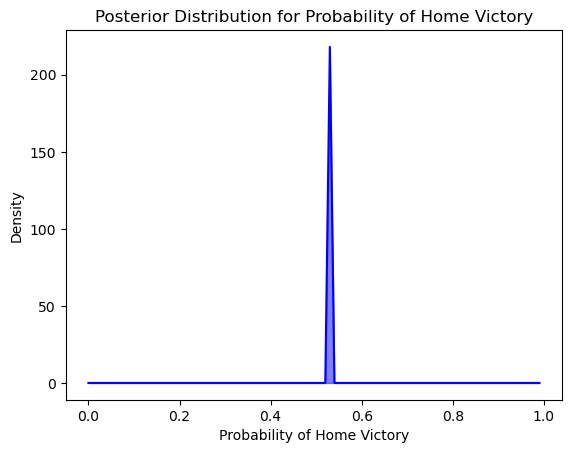

In [5]:
# Plot between 0 and 1 with .01 steps.
x_axis = np.arange(0, 1, .01)

# Plot the posterior distribution
plt.plot(x_axis, posterior_dist_hv.pdf(x_axis), label='Posterior Distribution', color='blue')
plt.fill_between(x_axis, posterior_dist_hv.pdf(x_axis), alpha=0.5, color='blue')
plt.title("Posterior Distribution for Probability of Home Victory")
plt.xlabel("Probability of Home Victory")
plt.ylabel("Density")
plt.show()